<a href="https://colab.research.google.com/github/hpsuresh12345/Python-code/blob/master/L%26t_Loan_default_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import XGBClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
from sklearn.model_selection import RandomizedSearchCV


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [0]:
train=pd.read_csv('train.csv')

In [149]:
len(train.columns[:-1])

40

In [150]:
train.describe()
train.info()
train.head()
train.tail()
train.shape
train.isna().sum()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,233154.000000,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.0,233154.00000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000
mean,535917.573376,54356.993528,7.586507e+04,74.746530,72.936094,19638.635035,69.028054,3396.880247,7.262243,1549.477148,1.0,0.84032,0.075577,0.144943,0.023242,0.002127,289.462994,2.440636,1.039896,0.156549,1.659001e+05,2.185039e+05,2.180659e+05,0.059081,0.027703,0.007244,5.427793e+03,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,0.217071
std,68315.693711,12971.314171,1.894478e+04,11.456636,69.834995,3491.949566,22.141304,2238.147502,4.482230,975.261278,0.0,0.36631,0.264320,0.352044,0.150672,0.046074,338.374779,5.217233,1.941496,0.548787,9.422736e+05,2.374794e+06,2.377744e+06,0.626795,0.316057,0.111079,1.702370e+05,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,0.412252
min,417428.000000,13320.000000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,476786.250000,47145.000000,6.571700e+04,68.880000,14.000000,16535.000000,48.000000,1511.000000,4.000000,713.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,535978.500000,53803.000000,7.094600e+04,76.800000,61.000000,20333.000000,86.000000,2970.000000,6.000000,1451.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,595039.750000,60413.000000,7.920175e+04,83.670000,130.000000,23000.000000,86.000000,5677.000000,10.000000,2362.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,678.000000,3.000000,1.000000,0.000000,3.500650e+04,6.250000e+04,6.080000e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,671084.000000,990572.000000,1.628992e+06,95.000000,261.000000,24803.000000,156.000000,7345.000000,22.000000,3795.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,890.000000,453.000000,144.000000,25.000000,9.652492e+07,1.000000e+09,1.000000e+09,52.000000,36.000000,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null object
Employment.Type                        225493 non-null object
DisbursalDate                          233154 non-null object
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag                   

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
233149,626432,63213,105405,60.72,34,20700,48,1050,01-08-88,Salaried,26-10-18,6,3705,1,0,0,1,0,0,735,D-Very Low Risk,4,3,0,390443,416133,416133,0,0,0,0,0,0,4084,0,0,0,1yrs 9mon,3yrs 3mon,0,0
233150,606141,73651,100600,74.95,34,23775,51,990,05-12-88,Self employed,23-10-18,6,3705,1,0,0,1,0,0,825,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,1565,0,0,0,0yrs 6mon,0yrs 6mon,0,0
233151,613658,33484,71212,48.45,77,22186,86,2299,01-06-76,Salaried,24-10-18,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
233152,548084,34259,73286,49.10,77,22186,86,2299,26-03-94,Salaried,29-09-18,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
233153,630213,75751,116009,66.81,77,22186,86,2299,18-02-84,Salaried,27-10-18,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


(233154, 41)

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

In [151]:
train.dtypes

UniqueID                                 int64
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
supplier_id                              int64
manufacturer_id                          int64
Current_pincode_ID                       int64
Date.of.Birth                           object
Employment.Type                         object
DisbursalDate                           object
State_ID                                 int64
Employee_code_ID                         int64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACC

In [152]:
# Since, 'MobileNo_Avl_Flag' has 0 variance.. We will be dropping this feature
print(train.MobileNo_Avl_Flag.var())

0.0


In [0]:
train.drop(['UniqueID','MobileNo_Avl_Flag','CREDIT.HISTORY.LENGTH','AVERAGE.ACCT.AGE'], axis=1, inplace=True)

In [0]:
# Setting up time marker
d_marker= '14-12-19'
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%d-%m-%y")
    d2 = datetime.strptime(d2, "%d-%m-%y")
    return abs((d2 - d1).days)

In [0]:
# age as on 1-1-2019 (in yrs)
train['Date.of.Birth'] = train['Date.of.Birth'].apply(lambda x:  days_between(x,d_marker)/365)
# Calculating time (in yrs) after disbursal
train['DisbursalDate']= train['DisbursalDate'].apply(lambda x:  days_between(x,d_marker)/365)

In [0]:
# Converting the given 'CREDIT.HISTORY.LENGTH' in months
#train['CREDIT.HISTORY.LENGTH']= train['CREDIT.HISTORY.LENGTH'].apply(lambda x: (re.sub('[a-z]','',x)).split())
#train['CREDIT.HISTORY.LENGTH']= train['CREDIT.HISTORY.LENGTH'].apply(lambda x: int(x[0])*12+int(x[1]))
# Converting the given 'AVERAGE.ACCT.AGE' in months
#train['AVERAGE.ACCT.AGE']= train['AVERAGE.ACCT.AGE'].apply(lambda x: (re.sub('[a-z]','',x)).split())
#train['AVERAGE.ACCT.AGE']= train['AVERAGE.ACCT.AGE'].apply(lambda x: int(x[0])*12+int(x[1]))

In [0]:
ct_col= ['branch_id','supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Employment.Type', 'State_ID', 'Employee_code_ID', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag','Driving_flag', 'Passport_flag','PERFORM_CNS.SCORE.DESCRIPTION']


con_col= ['disbursed_amount', 'asset_cost', 'ltv','Date.of.Birth','DisbursalDate', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES']

In [158]:
train[ct_col].head()

,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION
0,67,22807,45,1441,Salaried,6,1998,1,0,0,0,0,No Bureau History Available
1,67,22807,45,1502,Self employed,6,1998,1,0,0,0,0,I-Medium Risk
2,67,22807,45,1497,Self employed,6,1998,1,0,0,0,0,No Bureau History Available
3,67,22807,45,1501,Self employed,6,1998,1,0,0,0,0,L-Very High Risk
4,67,22807,45,1495,Self employed,6,1998,1,0,0,0,0,No Bureau History Available


In [159]:
train.isnull().sum()

disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                          0
PRI.OVERDUE.ACCTS                         0
PRI.CURRENT.BALANCE             

In [160]:
train['Employment.Type'].value_counts()

Self employed    127635
Salaried          97858
Name: Employment.Type, dtype: int64

In [161]:
print('Percentage of missing values is {0}% for the training set'.format(round(100*train['Employment.Type'].isnull().sum()/len(train),2)))

Percentage of missing values is 3.29% for the training set


In [162]:
# Substituting the null values by third category 'unknown'
train.fillna('unknown', inplace=True)
train['Employment.Type'].value_counts()

Self employed    127635
Salaried          97858
unknown            7661
Name: Employment.Type, dtype: int64

In [0]:
le = LabelEncoder()
train.iloc[:,8] = le.fit_transform(train.iloc[:,8])
train.iloc[:,18] = le.fit_transform(train.iloc[:,18])

In [0]:
#for i in con_col:
    train[i] = (train[i]- min(train[i])) / (max(train[i])- min(train[i]))

In [0]:
X= train.drop('loan_default', axis=1)
y= train.loan_default

In [166]:
train[ct_col].head()

,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION
0,67,22807,45,1441,0,6,1998,1,0,0,0,0,13
1,67,22807,45,1502,1,6,1998,1,0,0,0,0,8
2,67,22807,45,1497,1,6,1998,1,0,0,0,0,13
3,67,22807,45,1501,1,6,1998,1,0,0,0,0,11
4,67,22807,45,1495,1,6,1998,1,0,0,0,0,13


In [0]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [168]:
train[ct_col].info()
train[ct_col].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 13 columns):
branch_id                        233154 non-null int64
supplier_id                      233154 non-null int64
manufacturer_id                  233154 non-null int64
Current_pincode_ID               233154 non-null int64
Employment.Type                  233154 non-null int64
State_ID                         233154 non-null int64
Employee_code_ID                 233154 non-null int64
Aadhar_flag                      233154 non-null int64
PAN_flag                         233154 non-null int64
VoterID_flag                     233154 non-null int64
Driving_flag                     233154 non-null int64
Passport_flag                    233154 non-null int64
PERFORM_CNS.SCORE.DESCRIPTION    233154 non-null int64
dtypes: int64(13)
memory usage: 23.1 MB


,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE.DESCRIPTION
count,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.00000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000
mean,72.936094,19638.635035,69.028054,3396.880247,0.613144,7.262243,1549.477148,0.84032,0.075577,0.144943,0.023242,0.002127,9.570794
std,69.834995,3491.949566,22.141304,2238.147502,0.550378,4.482230,975.261278,0.36631,0.264320,0.352044,0.150672,0.046074,5.087599
min,1.000000,10524.000000,45.000000,1.000000,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,16535.000000,48.000000,1511.000000,0.000000,4.000000,713.000000,1.00000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,61.000000,20333.000000,86.000000,2970.000000,1.000000,6.000000,1451.000000,1.00000,0.000000,0.000000,0.000000,0.000000,13.000000
75%,130.000000,23000.000000,86.000000,5677.000000,1.000000,10.000000,2362.000000,1.00000,0.000000,0.000000,0.000000,0.000000,13.000000
max,261.000000,24803.000000,156.000000,7345.000000,2.000000,22.000000,3795.000000,1.00000,1.000000,1.000000,1.000000,1.000000,19.000000


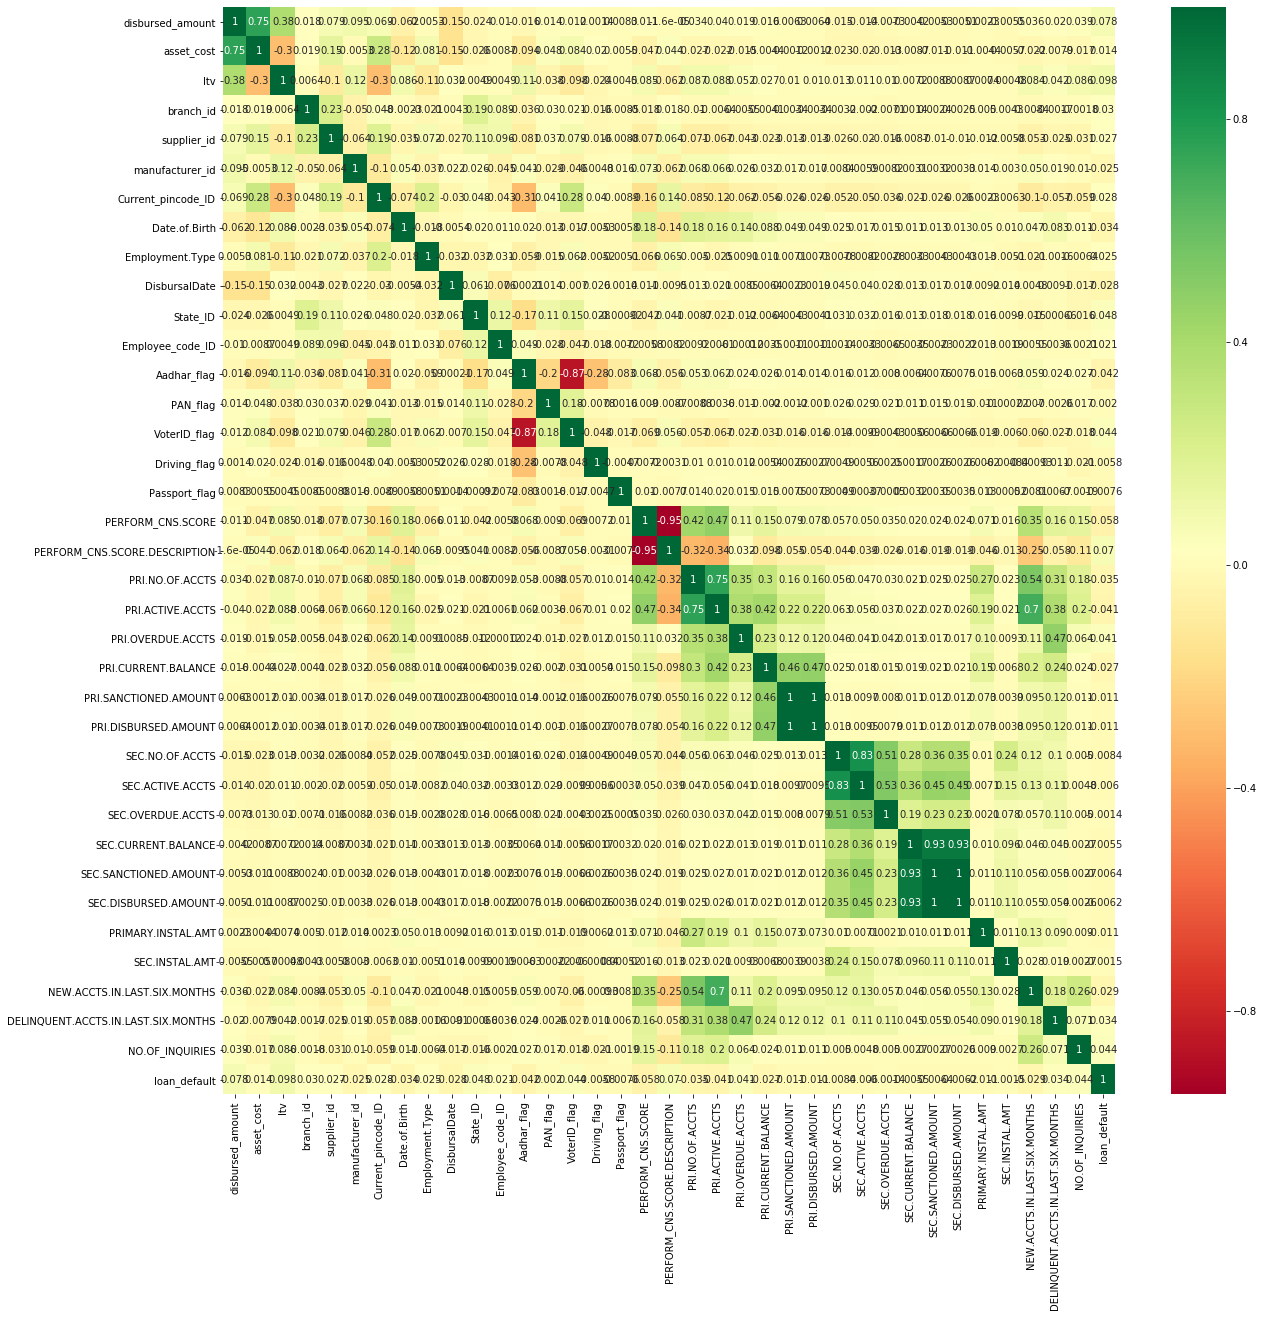

In [169]:
x=train.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(x,cmap='RdYlGn',annot=True)
plt.show();

In [0]:
X= train.drop('loan_default', axis=1)
y= train.loan_default

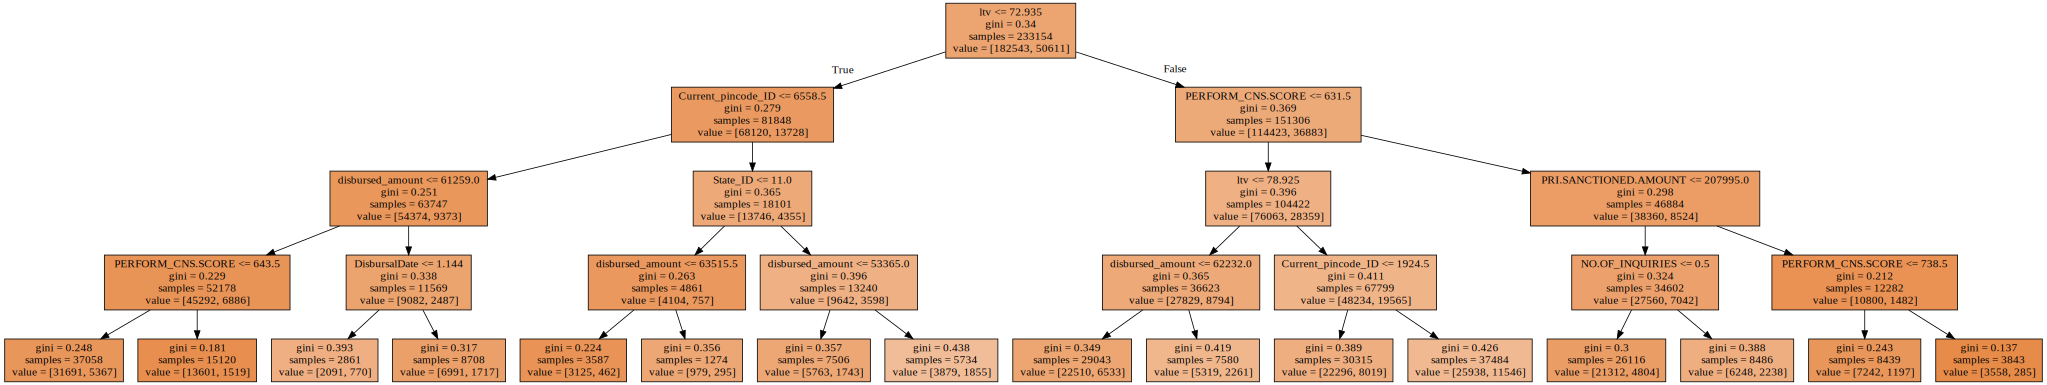

In [171]:
import graphviz
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X,y)
with open('tree.dot','w') as dotfile:
    tree.export_graphviz(clf,out_file=dotfile,feature_names=X.columns,filled=True)
    dotfile.close()
    
from graphviz import Source
with open('tree.dot','r') as f:
    text=f.read()
    plot=Source(text)
plot

# Decision tree classifier

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(186523, 36)

(186523,)

(46631, 36)

(46631,)

In [173]:
from sklearn import tree
my_tree_one = tree.DecisionTreeClassifier(max_depth=12)
my_tree_one
my_tree_one = my_tree_one.fit(X_train, y_train)
predicted = my_tree_one.predict(X_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
#Decision Tree Hyperparameters optimization using cross-validation 
criterion=['gini','entropy']
min_samples_split=[2,10,20,50,100]
max_depth=[20,30,None]

In [175]:
param_grid={'criterion':criterion, 'min_samples_split':min_samples_split,'max_depth':max_depth}
dt_g=GridSearchCV(my_tree_one, param_grid, cv=5,verbose = 2,n_jobs=-1)
dt_g.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=12,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 30, None],
                         'm

In [0]:
predicted=dt_g.predict(X_test)

In [177]:
metrics.accuracy_score(predicted, y_test)

0.7582509489395467

In [178]:
my_tree_one.feature_importances_
X.columns
features = pd.DataFrame(my_tree_one.feature_importances_,X.columns)
features
features.columns = ["Importance"]
features

array([0.11048214, 0.0498033 , 0.11468544, 0.02856225, 0.06005986,
       0.01335928, 0.07458392, 0.06863265, 0.01222995, 0.06588107,
       0.03503865, 0.04963039, 0.00864776, 0.00528102, 0.00344992,
       0.00118862, 0.00041722, 0.08954997, 0.00613611, 0.0180748 ,
       0.00767347, 0.0159249 , 0.02317445, 0.04114137, 0.02167768,
       0.00173343, 0.00119009, 0.00020328, 0.00197552, 0.00104771,
       0.00017787, 0.02893383, 0.00203311, 0.00518448, 0.01094112,
       0.02129336])

Index(['disbursed_amount', 'asset_cost', 'ltv', 'branch_id', 'supplier_id',
       'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'Passport_flag', 'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT',
       'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS',
       'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES'],
      dtype='object')

,0
disbursed_amount,0.110482
asset_cost,0.049803
ltv,0.114685
branch_id,0.028562
supplier_id,0.060060
manufacturer_id,0.013359
Current_pincode_ID,0.074584
Date.of.Birth,0.068633
Employment.Type,0.012230
DisbursalDate,0.065881


,Importance
disbursed_amount,0.110482
asset_cost,0.049803
ltv,0.114685
branch_id,0.028562
supplier_id,0.060060
manufacturer_id,0.013359
Current_pincode_ID,0.074584
Date.of.Birth,0.068633
Employment.Type,0.012230
DisbursalDate,0.065881


<Figure size 576x288 with 0 Axes>

Confusion Matrix


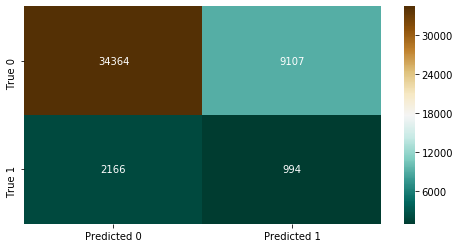

In [179]:
plt.figure(figsize=(8,4))
print('Confusion Matrix')
cf = metrics.confusion_matrix(predicted, y_test)
lbl1 = ["Predicted 0","Predicted 1"]
lbl2 = ["True 0","True 1"]
sns.heatmap(cf,annot=True,cmap ="BrBG_r", fmt="d", xticklabels=lbl1,yticklabels=lbl2)
plt.show()

In [180]:
dt_g.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [181]:
dt_g.best_score_

0.7591664298772806

In [182]:



cv=pd.DataFrame(dt_g.cv_results_)
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.165984,0.142126,0.029779,0.002741,gini,20,2,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.718402,0.716982,0.719233,0.715848,0.716518,0.717397,0.001243,18
1,5.137133,0.069482,0.037796,0.005292,gini,20,10,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.721619,0.723147,0.722530,0.721451,0.719521,0.721654,0.001232,17
2,5.068508,0.069728,0.030221,0.002094,gini,20,20,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.727302,0.725988,0.726310,0.725954,0.721638,0.725439,0.001962,15
3,4.938825,0.094571,0.025247,0.002045,gini,20,50,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.740732,0.745208,0.741697,0.740162,0.738607,0.741281,0.002205,8
4,4.650263,0.034634,0.026373,0.003776,gini,20,100,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.756145,0.757325,0.754966,0.755495,0.753592,0.755505,0.001239,2
5,5.804787,0.075171,0.035671,0.003285,gini,30,2,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.679909,0.677898,0.677443,0.677488,0.676817,0.677911,0.001057,28
6,5.811084,0.059737,0.034009,0.002634,gini,30,10,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.690283,0.689666,0.688674,0.688586,0.685557,0.688553,0.001626,24
7,5.624891,0.064236,0.033515,0.003169,gini,30,20,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.704276,0.701970,0.702346,0.701238,0.697512,0.701468,0.002218,19
8,5.525392,0.156541,0.029778,0.002546,gini,30,50,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.728830,0.731886,0.727436,0.727375,0.726330,0.728371,0.001929,11
9,5.115628,0.081105,0.026789,0.001430,gini,30,100,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.753009,0.751695,0.749095,0.749276,0.747668,0.750149,0.001929,4


# ROC curve function

In [0]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

# Confusion Matrix Viz function

In [0]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

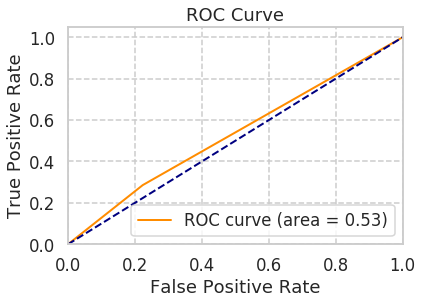

In [199]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_predict_probabilities = dt.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

# Naive Bayes classifier

In [188]:
# Fitting Logistic Regression to the Training set
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
# Predicting the Test set results
y_pred_nb= nb.predict(X_test)

In [190]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.87      0.06      0.11     36530
           1       0.22      0.97      0.36     10101

    accuracy                           0.25     46631
   macro avg       0.54      0.51      0.23     46631
weighted avg       0.73      0.25      0.16     46631



In [0]:
def confusion_matrix_c(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_label = ["Default", "No default"]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
def plot_roc_auc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


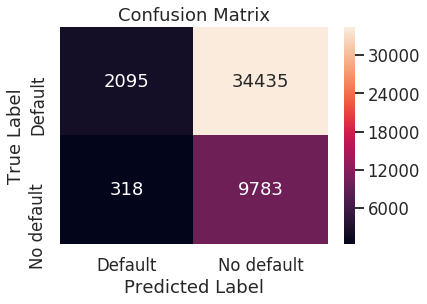

In [192]:
# Confusion Matrix
confusion_matrix_c(y_test, y_pred_nb)

In [193]:
#Score of Prediction
nb_score_train = nb.score(X_train,y_train)
print("Train Prediction Score",nb_score_train*100)
nb_score_test = accuracy_score(y_test,y_pred_nb)
print("Test Prediction Score",nb_score_test*100)

Train Prediction Score 25.5003404405891
Test Prediction Score 25.47232527717613


In [0]:
# For evaluating our ML results
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, auc

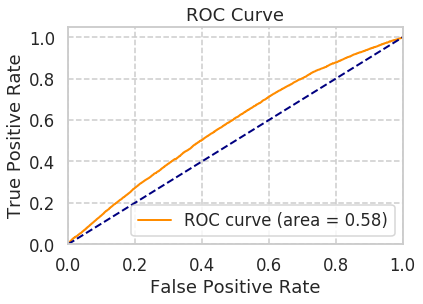

In [195]:
y_predict_probabilities = nb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

# Logistic Regression

In [196]:
# Fitting Logistic Regression to the Training set
lr= LogisticRegression(C=1,penalty='l1',random_state=42)
lr.fit(X_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Predicting the Test set results
y_pred_lr= lr.predict(X_test)

In [201]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     36530
           1       0.41      0.00      0.01     10101

    accuracy                           0.78     46631
   macro avg       0.60      0.50      0.44     46631
weighted avg       0.70      0.78      0.69     46631



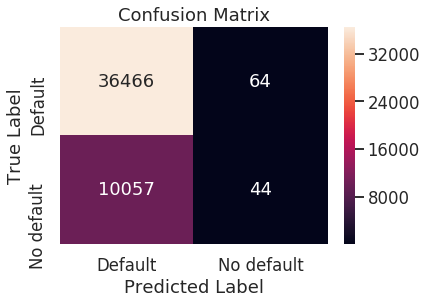

In [202]:
# Confusion Matrix
confusion_matrix_c(y_test, y_pred_lr)

In [203]:
#Score of Prediction
lr_score_train = lr.score(X_train,y_train)
print("Train Prediction Score",lr_score_train*100)
lr_score_test = accuracy_score(y_test,y_pred_lr)
print("Test Prediction Score",lr_score_test*100)

Train Prediction Score 78.25469245079695
Test Prediction Score 78.29555445947975


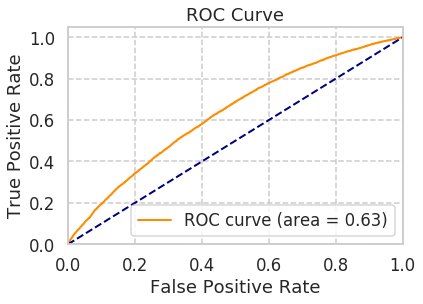

In [204]:
y_predict_probabilities = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

# K Nearest Neighbour

In [205]:
# Fitting KNN to the Training set
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
# Predicting the Test set results
y_pred_knn= lr.predict(X_test)

In [207]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     36530
           1       0.41      0.00      0.01     10101

    accuracy                           0.78     46631
   macro avg       0.60      0.50      0.44     46631
weighted avg       0.70      0.78      0.69     46631



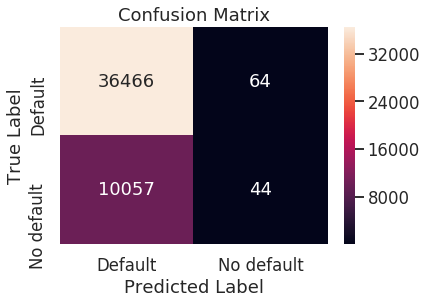

In [208]:
# Confusion Matrix
confusion_matrix_c(y_test, y_pred_knn)

In [209]:
#Score of Prediction
knn_score_train = knn.score(X_train,y_train)
print("Train Prediction Score",knn_score_train*100)
knn_score_test = accuracy_score(y_test,y_pred_knn)
print("Test Prediction Score",knn_score_test*100)

Train Prediction Score 80.71605110361725
Test Prediction Score 78.29555445947975


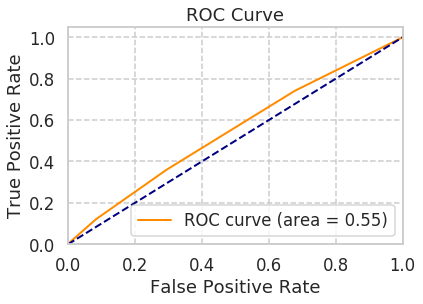

In [210]:
y_predict_probabilities = knn.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_auc_curve(fpr, tpr)

In [0]:
#from sklearn.neural_network import MLPClassifier
#clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
#clf_NN.fit(X_train,y_train)     
#predict_NN = clf_NN.predict(X_test)
#predictproba_NN = clf_NN.predict_proba(X_test)[:,1]
#NNAccuracy = accuracy_score(y_test,predict_NN)
#print(NNAccuracy)
#plotAUC(y_test,rfPredictproba, 'Random Forest')
#plotAUC(y_test,LR_Predict,'Logistic Regression')
#plotAUC(y_test,predictproba_svm, 'SVM')
#plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
#plotAUC(y_test,predictproba_NN,'MLP')
#plt.show()
#plt.figure(figsize=(6,6))
#plot_confusion_matrix(predict_NN, normalize=True)
#plt.show()